In [9]:
# Startup databrokers and elastic search
from pprint import pprint

from rapidz.graph import _clean_text, readable_graph
from xpdan.vend.callbacks.core import Retrieve
from xpdan.vend.callbacks.zmq import Publisher
from xpdconf.conf import glbl_dict

from databroker_elasticsearch import load_elasticindex
from databroker_elasticsearch.brokersearch import BrokerSearch

from databroker import Broker
import yaml
dbs = {}
for yaml_file in ['raw', 'an']:
    with open(f'{yaml_file}.yml', 'r') as f:
        dbs[yaml_file] = Broker.from_config(yaml.load(f))
from databroker_elasticsearch.converters import register_converter


def filtertype(seq, tp):
    return (o for o in seq if isinstance(o, tp))


@register_converter
def tomo_usednodes(graph):
    nodes = []
    fmt = '{mod}.{name}'
    for n in graph['nodes']:
        st = n['stream']
        e = dict()
        e['ndtype'] = fmt.format(**st)
        ad = next(filtertype(st['args'], dict), None)
        al = next(filtertype(st['args'], list), None)
        if ad is not None:
            e['ndfunc'] = fmt.format(**ad)
        elif al is not None:
            e['ndfunc'] = next(filtertype(al, str))
        nodes.append(e)
    return nodes
        
an_db = dbs['an']
raw_db = dbs['raw']
raw_es = load_elasticindex('es-raw.yaml')
an_es = load_elasticindex('es-an.yaml')
raw_db_es = BrokerSearch(raw_db, raw_es)
an_db_es = BrokerSearch(an_db, an_es)

In [5]:
# query raw es for dino tooth, print output
raw_es.qsearch()

{'took': 11,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 3,
  'max_score': 1.0,
  'hits': [{'_index': 'demo-raw',
    '_type': 'run_start',
    '_id': '008a4cb5-2347-41a4-b706-d9c7a2228cfa',
    '_score': 1.0,
    '_source': {'detectors': ['img'],
     'num_points': 64,
     'plan_name': 'list_scan',
     'scan_id': 2,
     'time': 1554910887.7045174,
     'uid': '008a4cb5-2347-41a4-b706-d9c7a2228cfa',
     'date': '2019-04-10T11:41:27.705',
     'sample_name': 'sabertooth tiger tooth'}},
   {'_index': 'demo-raw',
    '_type': 'run_start',
    '_id': '52392de2-406f-40fe-b346-769f5c5909ca',
    '_score': 1.0,
    '_source': {'detectors': ['img'],
     'num_points': 64,
     'plan_name': 'list_scan',
     'scan_id': 1,
     'time': 1554910824.5516207,
     'uid': '52392de2-406f-40fe-b346-769f5c5909ca',
     'date': '2019-04-10T11:40:24.552',
     'sample_name': 'sabertooth tiger tooth'}},
   {'_index': 'demo-raw',
    '_ty

In [15]:
# query an_es/databroker for tomo recon
hdrs = an_db_es()
tomo_analysis_hdr = next(iter(hdrs))
print(tomo_analysis_hdr.stop)


Run Stop
exit_status     : success                                 
num_events      :
run_start       : 2d7e6767-5033-495b-96b4-cff8270e55b6    
time            : 1554910921.28256                        
times           :
    node            : b585e13f-6a1c-4031-b7af-97ebcaf73325    
    uid             : 008a4cb5-2347-41a4-b706-d9c7a2228cfa    
    node            : b585e13f-6a1c-4031-b7af-97ebcaf73325    
    uid             : 27d34cdb-2ca9-4a12-81d4-eebbb740cca8    
    node            : b585e13f-6a1c-4031-b7af-97ebcaf73325    
    uid             : ddfa0a65-c725-4473-b6df-0e6dd9c26bd1    
    node            : b585e13f-6a1c-4031-b7af-97ebcaf73325    
    uid             : ddfa0a65-c725-4473-b6df-0e6dd9c26bd1/0  
    node            : b585e13f-6a1c-4031-b7af-97ebcaf73325    
    uid             : 319d5982-4345-4ff2-a3e5-bf27fbbe4526    
    node            : b585e13f-6a1c-4031-b7af-97ebcaf73325    
    uid             : ddfa0a65-c725-4473-b6df-0e6dd9c26bd1/1  
    node            :

uid             : a3b5cbd8-64d2-4777-ae2a-eab10619a63b    


/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/dxchange/reader.py:97: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(modname + ' module not found')


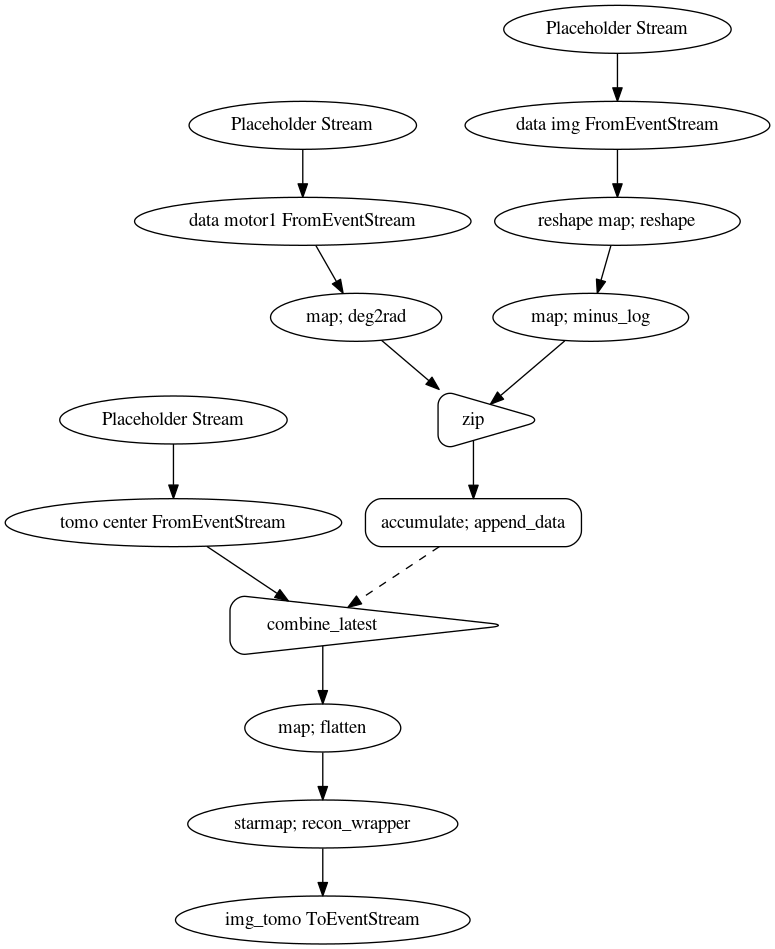

In [16]:
# replay analysis with no changes
from shed.replay import replay

# load the replay
graph, parents, data, vs = replay(raw_db, tomo_analysis_hdr)

# make the graph more accessible to humans by renaming things
# these names *should* match the names in the graph plot
for k, v in graph.nodes.items():
    v.update(label=_clean_text(str(v['stream'])).strip())
graph = readable_graph(graph)

# plot the graph
graph.nodes['data img FromEventStream']['stream'].visualize()

In [17]:
# print the current reconstruction algorithm
print(graph.nodes['starmap; recon_wrapper']['stream'].kwargs)

# setup a publisher to send over to data viz
p = Publisher(glbl_dict['inbound_proxy_address'], prefix=b'tomo')
graph.nodes['img_tomo ToEventStream']['stream'].DBFriendly().starsink(p)

# rerun data processing
r = Retrieve(dbs['raw'].reg.handler_reg)
for v in vs:
    d = data[v['uid']]
    dd = r(*d)
    parents[v["node"]].update(dd)

{'algorithm': 'gridrec'}


In [18]:
# replay with changes
# print the current reconstruction algorithm
print(graph.nodes['starmap; recon_wrapper']['stream'].kwargs)

# change to Algebreic
graph.nodes['starmap; recon_wrapper']['stream'].kwargs['algorithm'] = 'art'
print(graph.nodes['starmap; recon_wrapper']['stream'].kwargs)

# setup a publisher to send over to data viz
p = Publisher(glbl_dict['inbound_proxy_address'], prefix=b'tomo')
graph.nodes['img_tomo ToEventStream']['stream'].DBFriendly().starsink(p)

# rerun data processing
r = Retrieve(dbs['raw'].reg.handler_reg)
for v in vs:
    d = data[v['uid']]
    dd = r(*d)
    parents[v["node"]].update(dd)

{'algorithm': 'gridrec'}
{'algorithm': 'art'}


KeyboardInterrupt: 

In [5]:
# Compare results

In [ ]:
# an_es for new data (via new recon algo)